<a href="https://colab.research.google.com/github/arnoldjames98/arnoldjames98.github.io/blob/main/systemDynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Biodegradable Seed Spreading Robot](https://arnoldjames98.github.io/)
# System Dynamics

### 1. Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.


**Table I. Mechanism Lengths**

| Length | Rigid Body | Measurement (m)
| --- | --- | --- |
| L10 | Yellow | 0.03 |
| L02 | Purple | 0.0689 |
| L42 | Purple | 0.0973 |
| L40 | Purple | 0.0737 |
| L31 | Red | 0.066 |
| L61 | Red | 0.1236 | 
| L63 | Red | 0.0584 |
| L54 | Green | 0.0579 |
| L32 | Orange | 0.0359 |
| L56 | Blue | 0.1004 |
| L5E | Blue | 0.1940 |
| LE6 | Blue | 0.1004 |

**Table II. Mechanism Masses**

| Rigid Body | Mass (kg)
| --- | --- |
| Yellow | 0 |
| Purple | 0 |
| Red | 0 |
| Green | 0 |
| Orange | 0 |
| Blue | 0 |

Show plots inline and ensure that pynamics is installed.

In [1]:
%matplotlib inline
!pip install pynamics

Import all required packages. Packages related to dynamics are commented out since they are not needed for this assignment, but will be used in the future.

In [2]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body # New for this assignment
from pynamics.dyadic import Dyadic # New for this assignment
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle # New for this assignment
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
from pynamics.constraint import Constraint # New for this assignment
import scipy.optimize

Create a pynamics system where the mechanism is located.

In [3]:
system = System()
pynamics.set_system(__name__,system)

Declare all length constants and ground coordinate locations.

In [4]:
# All lengths converted to meters from the previous assignment
# Put all meaured lengths in meters in a list so that if we chose to change these
# in the future, they can all be scaled up or down with a single multiplier
allLengths = [0.03, 0.066, 0.0359, 0.068877, 0.12363, 0.1004, 0.0579, 0.073736, \
              0.0584, 0.0973, 0.1004, 0.19396]

groundCoords = [-0.066, -0.0197, -0.026, 0.069]

lengthScale = 1 # Default is 1, means that the measurements in allLengths and groundCoords will be unchanged from above

allLengths = allLengths*lengthScale
groundCoords = groundCoords*lengthScale

# From Loop Closure Eq. #1
l_10 = Constant(allLengths[0],'l_10',system)
l_31 = Constant(allLengths[1],'l_31',system)
l_32 = Constant(allLengths[2],'l_32',system)
l_02 = Constant(allLengths[3],'l_02',system)

# From Loop Closure Eq. #2
#l_10 already is included in Eq. 1
l_61 = Constant(allLengths[4],'l_61',system)
l_56 = Constant(allLengths[5],'l_56',system)
l_54 = Constant(allLengths[6],'l_54',system)
l_40 = Constant(allLengths[7],'l_54',system)

# Other lengths
l_63 = Constant(allLengths[8],'l_63',system)
l_42 = Constant(allLengths[9],'l_42',system)

# End effector
l_E6 = Constant(allLengths[10],'l_E6',system)
l_5E = Constant(allLengths[11],'l_5E',system)

# Moved the coordinates of the ground link here since they need to be scaled
# the same has lengths
# Ground link coordinates
p2_x = Constant(groundCoords[0],'p2_x',system)
p2_y = Constant(groundCoords[1],'p2_y',system)
p4_x = Constant(groundCoords[2],'p4_x',system)
p4_y = Constant(groundCoords[3],'p4_y',system)

# Consider adding the constant angle constraints in the future

Declare all masses of the links

In [5]:
# Found some masses by estimating the length/perimeters in m of the different links in Cree's prototype
# This means the "triangular links" are not considered as rigid bodies, but inside just the sides matter
# Note that the blue and red triangular links actually only include 2 of the three sides in Cree's prototype
allMasses = [0.0300, 0.0359, 0.0579, 0.1244, 0.2004, 0.2399]

# Assuming we use 300 g/m2 heavy cardstock and all links are about 0.02m width by the length
# 0.3 kg / 0.02 m = 15 kg/m
massScale = 15 # Converts the length/perimeter based mass estimates a more realistic value for cardstock
allMasses = allMasses*massScale

mY = Constant(allMasses[0],'mY',system) # Mass of yellow input link
mO = Constant(allMasses[1],'mO',system) # Mass of orange link
mG = Constant(allMasses[2],'mG',system) # Mass of green link
mR = Constant(allMasses[3],'mR',system) # Mass of red link
mB = Constant(allMasses[4],'mB',system) # Mass of blue link
mP = Constant(allMasses[5],'mP',system) # Mass of purple groundlink

Define forces in Newtons

In [ ]:
#TODO: I think we just need the ground reaction force here



---


### 2. Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame. You may use particles for now if you are not sure of the inertial properties of your bodies, but you should plan on finding these values soon for any “payloads” or parts of your system that carry extra loads (other than the weight of paper).

#### First, defining the inertias

In [6]:
# Diagonal entries of the interia matricies
# For rectangular links, I think something like: https://www.google.com/search?q=inertia+matrix+of+rectangle&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiskPO74YHvAhXwITQIHa09C7QQ_AUoAXoECBMQAw&biw=1440&bih=764#imgrc=pdWYree46q8xbM
# Where diagonal elements are (1/12 * mass * (lengthSideY^2 - lengthSideZ^2) for example
# The triangular links are bit trickier. I think we can do it in SolidWorks
# Note that the frames are defined in the sections below, but are important for 
# identifying which dimension is x (along frame), y (orthogonal to frame), or z (out of the page)

# TODO: Update these diagonal intertia matrix elements based on the geometry of Cree's prototype

# Inertia of yellow link (rectangle) w.r.t Y frame
Ixx_Y = Constant(1,'Ixx_Y',system)
Iyy_Y = Constant(1,'Iyy_Y',system)
Izz_Y = Constant(1,'Izz_Y',system)

# Inertia of orange link (rectangle)
Ixx_O = Constant(1,'Ixx_O',system)
Iyy_O = Constant(1,'Iyy_O',system)
Izz_O = Constant(1,'Izz_O',system)

# Inertia of green link (rectangle)
Ixx_G = Constant(1,'Ixx_G',system)
Iyy_G = Constant(1,'Iyy_G',system)
Izz_G = Constant(1,'Izz_G',system)

# Inertia of red link (two sides of triagle)
Ixx_R = Constant(1,'Ixx_R',system)
Iyy_R = Constant(1,'Iyy_R',system)
Izz_R = Constant(1,'Izz_R',system)

# Inertia of blue link (two sides of triagle)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)

# Inertia of purple link (three sides of triagle)
Ixx_P = Constant(1,'Ixx_P',system)
Iyy_P = Constant(1,'Iyy_P',system)
Izz_P = Constant(1,'Izz_P',system)

#### NOTE: Some additionally code from the kinematics assignment is needed to define the frames, since the center of masses require that the frames be defined.

Create the differentiable state variables, cooresponding to the joint angles (we might not need all of these depending on how we do the constraints)

In [34]:
# Note: All angles are measured CCW

# Input state variable (angle of crank on yellow link)
qY,qY_d,qY_dd = Differentiable('qY',system) # Yellow input link, measured from base frame coordinates

# Other state variables (angles of the four undefined links)
# Note that the purple link is ground so is fully defined
qO,qO_d,qO_dd = Differentiable('qO',system) # Orange link w.r.t base frame
qG,qG_d,qG_dd = Differentiable('qG',system) # Green link w.r.t base frame

# Links defined w.r.t non-ground link (not connected to ground)
qR,qR_d,qR_dd = Differentiable('qR',system) # Red link w.r.t yellow link frame
qB,qB_d,qB_dd = Differentiable('qB',system) # Blue link w.r.t green link frame

Initial guess for starting positions

In [35]:
# TODO: We can measure the angles on our directly from our figure to make some guesses
initialvalues = {}
# Yellow link w.r.t base
initialvalues[qY]=130*pi/180 #130*pi/180 (positive) is the input for which I estimated the other angles
initialvalues[qY_d]=0

# Orange link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qO]=130*pi/180
initialvalues[qO_d]=0

# Green link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qG]=160*pi/180
initialvalues[qG_d]=0

# Red link w.r.t yellow link frame
initialvalues[qR]=30*pi/180
initialvalues[qR_d]=0

# Blue link w.r.t green link frame
initialvalues[qB]=60*pi/180
initialvalues[qB_d]=0

Retrieve state variables in the order they are stored in the system

In [36]:
# Not sure if we need this, but it's included in the tutorial
statevariables = system.get_state_variables()

Create the main reference frames, with one cooresponding to each rigid link

In [37]:
N = Frame('N') # Purple (ground) link

# Defined w.r.t to ground
Y = Frame('Y') # Yellow
O = Frame('O') # Orange
G = Frame('G') # Green

# Defined w.r.t to other links 
# Note that both are directed towards p6
# Important since this is how the angle representing the link is defined
R = Frame('R') # Red w.r.t yellow
B = Frame('B') # Blue w.r.t green

# Helpful additional frames for triangular links
# These frames define the constant angles within the triangular joints
R_to_p3 = Frame('R_to_p3') # Red w.r.t yellow (+ constant degrees to align x-axis with p3)
B_to_pE = Frame('B_to_pE') # Blue w.r.t green (+ constant degrees to align x-axis with pE)
B_plus_180 = Frame('B_plus_180') # Blue with x axis in opposite direction
R_from_p3 = Frame('R_from_p3') # Red rotated so that it can point from p3 to p6 (CW rotation)
B_from_p6 = Frame('B_from_p6') # Blue rotated so it can go from p6 to pE

Declare N as the Newtonian (fixed) frame

In [38]:
system.set_newtonian(N)

Rotate frames about their z-axes so they align with the correct rigid link.

In [39]:
# Frames cooresponding to joint angles
Y.rotate_fixed_axis_directed(N,[0,0,1],qY,system) # Yellow
O.rotate_fixed_axis_directed(N,[0,0,1],qO,system) # Orange
G.rotate_fixed_axis_directed(N,[0,0,1],qG,system) # Green
R.rotate_fixed_axis_directed(Y,[0,0,1],qR,system) # Red w.r.t yellow
B.rotate_fixed_axis_directed(G,[0,0,1],qB,system) # Blue w.r.t green

# Helpful frames for triangular joints
# 6.007 degrees from B frame to align axis with p3
R_to_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR+6.007*pi/180,system) # Red w.r.t yellow
# 15 degrees from B frame to align axis with pE
B_to_pE.rotate_fixed_axis_directed(G,[0,0,1],qB+15*pi/180,system) # Blue w.r.t green
# B plus 180 (this comes in handy later when defining a vector in the opposite direction)
B_plus_180.rotate_fixed_axis_directed(G,[0,0,1],qB+180*pi/180,system) # Blue reversed
# R - 5.84 degrees (CW rotation) from p3 to p6
R_from_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR-12.8*pi/180,system) # Red w.r.t yellow
# Rotate B frame 30 degrees CCW to go from p6 to pE
B_from_p6.rotate_fixed_axis_directed(G,[0,0,1],qB+30*pi/180,system)

#### Now with the frames defined, the **center of masses** can be considered

In [13]:
#TODO

# Center of mass for each link, requires information about frames
# For the triangular links, we will need to consider both the x and y components
# since the COM will not be located along any frame like for the straight joints where it is in the middle

# These ones are easy: just in the middle of the length along the correct frame
#cmY=
#cmO=
#cmG=

# These ones need x and y components
#cmR=
#cmB=
#cmP=

The next several lines compute the inertia dyadics of each body and define a rigid body on each frame.

In [ ]:
# Define the intertia w.r.t to the appropriate frames
IY = Dyadic.build(Y,Ixx_Y,Iyy_Y,Izz_Y)
IO = Dyadic.build(O,Ixx_O,Iyy_O,Izz_O)
IG = Dyadic.build(G,Ixx_G,Iyy_G,Izz_G)
IR = Dyadic.build(R,Ixx_R,Iyy_R,Izz_R)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IP = Dyadic.build(N,Ixx_P,Iyy_P,Izz_P) # Purple link is in Newtonian frame

# TODO: Define the bodies that describe the mass/inertial properties of each link
BodyY = Body('BodyY',Y,cmY,mY,IY,system)
#BodyO = ....

# An alternative approach is to represent each mass as a particle at a certain point
#BodyC = Particle(pCcm,mC,'ParticleC',system)



---


### 3. Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint. You do not need to add external motor/spring forces but you should start planning to collect that data.

In [14]:
# THIS SECTION IS NOT DONE, SOME PARTS PASTED FROM TRIPLE PENDULUM EXAMPLE

# Gravity
g = Constant(9.81,'g',system)

# TODO: We will probably need to add more of these variables specific to certain joints
# These may also need to be moved to another section
b = Constant(1e1,'b',system) # Damping
k = Constant(1e1,'k',system) # Stiffness

# Stiffness equilibrium (where joint naturally wants to be) for each joint
# It seems like 
# We will need to update the angles with ones that make sense based on how the paper joints are folded
preloadY = Constant(0*pi/180,'preload0',system)
preloadO = Constant(0*pi/180,'preload1',system)
preloadG = Constant(0*pi/180,'preload2',system)
preloadR = Constant(0*pi/180,'preload3',system)
preloadB = Constant(0*pi/180,'preload4',system)

# Question: The frames for this part are confusing
# For example, should the force on qY be in the Y frame or N frame?
# Also, need to define angular velocities to do this part
#system.add_spring_force1(k,(qY-preloadY)*N.z,ANGULARVELOCITY) 
# TODO: Finish this




---


### 4. Constraints: Keep mechanism constraints in, but follow the pendulum example of double-differentiating all constraint equations.
*   If you defined your mechanism as unattached to the Newtonian frame, add enough constraints so that it is fully attached to ground (for now). you will be eventually removing these constraints.


Define vectors for each of the joint locations.
*Note: Not all vectors here are necessary for the chosen loop closure equations, but are kept here since they could be useful in future assignments.*

In [15]:
# Vectors representing the joint locations w.r.t N frame
# Fixed points on purple (ground) link
p0 = 0*N.x # P0 is at the origin
p2 = p2_x*N.x + p2_y*N.y # Coordinates given (in meters)
p4 = p4_x*N.x + p4_y*N.y # Coordinates given (in meters)

# Note that for all other points, they are still w.r.t N frame, but they can be defined from different directions/pathways
# Defining the same point from different directions/pathways is needed for constraints
# Points directly connected to ground
p1_from_p0 = p0 + l_10*Y.x
p3_from_p2 = p2 + l_32*O.x
p5_from_p4 = p4 + l_54*G.x

# Additional points (Consider alternative defnitions of these)
p6_from_p1 = p1_from_p0 + l_61*R.x
pE_from_p5 = p5_from_p4 + l_5E*B_to_pE.x # 15 degrees CCW from B frame x axis

# Alternate pathways to points (used to make LHS and RHS of loop equations defined differently)
p3_from_p1 = p1_from_p0 + l_31*R_to_p3.x # 6.007 degrees (CCW) from R frame x axis
p5_from_p6 = p6_from_p1 + l_56*B_plus_180.x # 180 degress (CCW) from B frame x axis
p6_from_p3 = p3_from_p2 + l_63*R_from_p3.x # -5.84 degress (CW) from R frame x axis
pE_from_p6 = p6_from_p3 + l_E6*B_from_p6.x

# List of points to that will be used for plotting 
# Doesn't matter which version of points like p1 we use since they will be constrained to be equal
points = [p0, p1_from_p0, p2, p3_from_p2, p4, p5_from_p4, p6_from_p1, pE_from_p6]

Create a list of initial values ini0 in the order of the system’s state variables

In [16]:
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

Create all the vector equation constraints (e.g., loop closure equations, rigid link constraints, etc.)

In [17]:
# Loop closure equations (constraint to ensure all loops are equal to zero)
# Equation 1 (R02 + R10 + R31 = R32)
loopClosure1 = p3_from_p1 - p3_from_p2

# Equation 2 (R10 + R61 + R56 = R40 + R54)
loopClosure2 = p5_from_p4 - p5_from_p6

Convert the vector constraints into scalar equations that can be solved

In [18]:
eq = [] # Initialize

# Loop closure equations
eq.append((loopClosure1).dot(N.x))
eq.append((loopClosure1).dot(N.y))

eq.append((loopClosure2).dot(N.x))
eq.append((loopClosure2).dot(N.y))

# Show the equations
print(eq)

# Take the derivatives
eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d] # Added for this assignment

# Show the derivatives
print(eq_d)

[l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299) - l_32*cos(qO) - p2_x, l_10*sin(qY) + l_31*sin(qY)*cos(qR + 0.104841928167299) + l_31*sin(qR + 0.104841928167299)*cos(qY) - l_32*sin(qO) - p2_y, -l_10*cos(qY) + l_54*cos(qG) + l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979) + l_61*sin(qR)*sin(qY) - l_61*cos(qR)*cos(qY) + p4_x, -l_10*sin(qY) + l_54*sin(qG) - l_56*sin(qG)*cos(qB + 3.14159265358979) - l_56*sin(qB + 3.14159265358979)*cos(qG) - l_61*sin(qR)*cos(qY) - l_61*sin(qY)*cos(qR) + p4_y]
[l_32*qO_d*sin(qO) + qR_d*(-l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY)) + qY_d*(-l_10*sin(qY) - l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY)), -l_32*qO_d*cos(qO) + qR_d*(-l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299)) + qY_d*(l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR



---


### 5. Solution: Add the code from the bottom of the pendulum example for solving for f=ma, integrating, plotting, and animating. Run the code to see your results. It should look similar to the pendulum example with constraints added, as in like a rag-doll or floppy

In [14]:
# TODO
#f,ma = system.getdynamics()



---


### 6. Tuning: Now adjust the damper value `b` to something nonzero, that over 10s shows that the system is settling.



---


### 7. (Optional): Adjust joint stiffness values so that your system looks more realistic.



---


# ALL THE CODE BELOW IS FROM THE PREVIOUS ASSIGNMENT. MOVE SECTIONS UP AS NEEDED

identify independent and dependent variables

In [19]:
qi = [qY] # Yellow link is the input
qd = [qO, qG, qR, qB] # All other links are dependent on the input

For dependent variables, create an initial guess and create a copy of symbolic constants dictionary and add the initial value of qi to it

In [20]:
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

Substitute constants in equation

In [21]:
eq = [item.subs(constants) for item in eq]
print(eq)

[-0.0505589332458526*sin(qR + 0.104841928167299) - 0.0359*cos(qO) - 0.0424239822393116*cos(qR + 0.104841928167299) + 0.0467163717094038, -0.0359*sin(qO) - 0.0424239822393116*sin(qR + 0.104841928167299) + 0.0505589332458526*cos(qR + 0.104841928167299) + 0.0426813332935693, 0.1004*sin(qG)*sin(qB + 3.14159265358979) + 0.0947060745027992*sin(qR) - 0.1004*cos(qG)*cos(qB + 3.14159265358979) + 0.073736*cos(qG) + 0.0794678321855469*cos(qR) - 0.00671637170940382, -0.1004*sin(qG)*cos(qB + 3.14159265358979) + 0.073736*sin(qG) + 0.0794678321855469*sin(qR) - 0.1004*sin(qB + 3.14159265358979)*cos(qG) - 0.0947060745027992*cos(qR) + 0.0460186667064307]


convert to numpy array

sum the error

In [22]:
error = (numpy.array(eq)**2).sum()


### 4. Select or solve for a valid initial condition that represents the system in the middle of a typical gait, when it is both moving and when forces are being applied to it (or to the world by it)

Convert to a function that scipy can use. Sympy has a “labmdify” function that evaluates an expression, but scipy needs a slightly different format.

In [23]:
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

Take the derivative of the equations to linearize with regard to the velocity variables

In [24]:
guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
print("Tolerance:", result.fun)

ini = []

for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))

2021-02-24 05:18:20,638 - pynamics.output - INFO - calculating outputs
2021-02-24 05:18:20,640 - pynamics.output - INFO - done calculating outputs


Tolerance: 3.5171053889687647e-09


array([[[ 0.        ,  0.        ],
        [-0.01928363,  0.02298133],
        [-0.066     , -0.0197    ],
        [-0.08907608,  0.007801  ],
        [-0.026     ,  0.069     ],
        [-0.09528918,  0.0942192 ],
        [-0.13545783,  0.06526528],
        [-0.17250399, -0.05490838]],

       [[ 0.        ,  0.        ],
        [-0.01928363,  0.02298133],
        [-0.066     , -0.0197    ],
        [-0.08418034,  0.01125618],
        [-0.026     ,  0.069     ],
        [-0.09251286,  0.10082825],
        [-0.14257361,  0.0138185 ],
        [-0.14179173, -0.08046163]]])

### 5. Plot the system in this position.

Create a plot of the optimized points defining the mechanism.

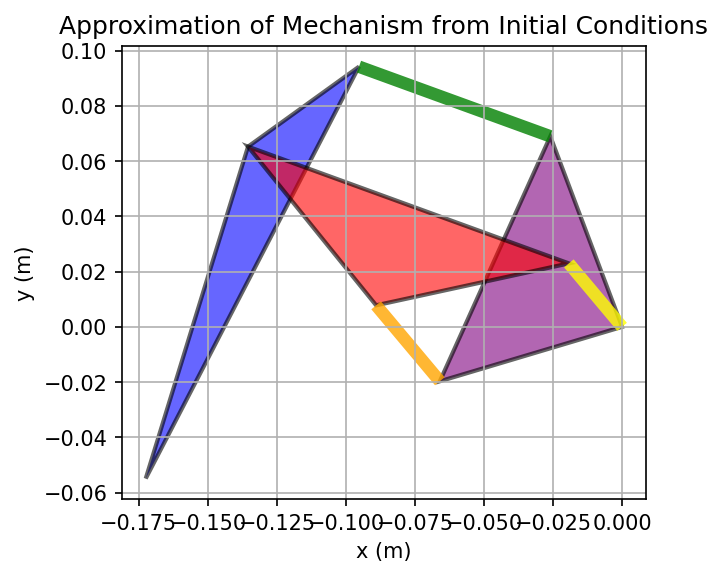

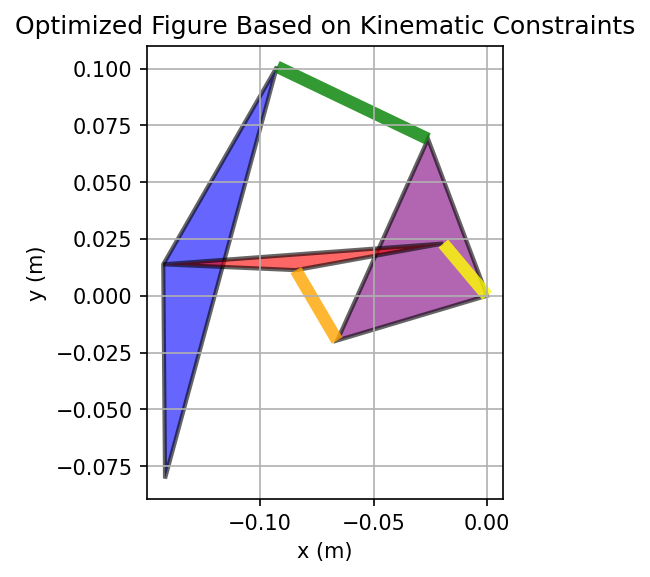

In [25]:
# Figure when inputting the guesses for intial joint angles
plt.figure(dpi=150)
# Blue link
plt.fill([points.y[0][7,0], points.y[0][6,0], points.y[0][5,0]], [points.y[0][7,1], points.y[0][6,1], points.y[0][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
# Purple link
plt.fill([points.y[0][0,0], points.y[0][2,0], points.y[0][4,0]], [points.y[0][0,1], points.y[0][2,1], points.y[0][4,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
# Red link
plt.fill([points.y[0][1,0], points.y[0][3,0], points.y[0][6,0]], [points.y[0][1,1], points.y[0][3,1], points.y[0][6,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
# Orange link
plt.fill([points.y[0][2,0], points.y[0][3,0]], [points.y[0][2,1], points.y[0][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
# Green link
plt.fill([points.y[0][4,0], points.y[0][5,0]], [points.y[0][4,1], points.y[0][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
# Yello link
plt.fill([points.y[0][0,0], points.y[0][1,0]], [points.y[0][0,1], points.y[0][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)

# Make the plot readable
plt.title('Approximation of Mechanism from Initial Conditions')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.grid()
plt.axis('scaled')
plt.show()


# Figure for the correct joint angles optimized from the guessed initial conditions
plt.figure(dpi=150)
# Blue link
plt.fill([points.y[1][7,0], points.y[1][6,0], points.y[1][5,0]], [points.y[1][7,1], points.y[1][6,1], points.y[1][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
# Purple link
plt.fill([points.y[1][0,0], points.y[1][2,0], points.y[1][4,0]], [points.y[1][0,1], points.y[1][2,1], points.y[1][4,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
# Red link
plt.fill([points.y[1][1,0], points.y[1][3,0], points.y[1][6,0]], [points.y[1][1,1], points.y[1][3,1], points.y[1][6,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
# Orange link
plt.fill([points.y[1][2,0], points.y[1][3,0]], [points.y[1][2,1], points.y[1][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
# Green link
plt.fill([points.y[1][4,0], points.y[1][5,0]], [points.y[1][4,1], points.y[1][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
# Yello link
plt.fill([points.y[1][0,0], points.y[1][1,0]], [points.y[1][0,1], points.y[1][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)

plt.title('Optimized Figure Based on Kinematic Constraints')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid()
plt.axis('scaled')
plt.show()

#### 3.6-7 Create the Jacobian

Turn constraint equations into a vector

In [26]:
eq_d = sympy.Matrix(eq_d)
print(eq_d)

Matrix([[l_32*qO_d*sin(qO) + qR_d*(-l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY)) + qY_d*(-l_10*sin(qY) - l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY))], [-l_32*qO_d*cos(qO) + qR_d*(-l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299)) + qY_d*(l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299))], [qB_d*(l_56*sin(qG)*cos(qB + 3.14159265358979) + l_56*sin(qB + 3.14159265358979)*cos(qG)) + qG_d*(-l_54*sin(qG) + l_56*sin(qG)*cos(qB + 3.14159265358979) + l_56*sin(qB + 3.14159265358979)*cos(qG)) + qR_d*(l_61*sin(qR)*cos(qY) + l_61*sin(qY)*cos(qR)) + qY_d*(l_10*sin(qY) + l_61*sin(qR)*cos(qY) + l_61*sin(qY)*cos(qR))], [qB_d*(l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979)) + qG_d*(l_54*cos(qG) + l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979)) + qR_d*(l_61*sin(qR)*sin(qY)

Turn qi and qd into sympy vectors

In [27]:
qi = sympy.Matrix([qY_d])
qd = sympy.Matrix([qO_d,qG_d,qR_d,qB_d])